# Identity Resolution with Kanoniv - Full Tutorial

**The problem:** Your customers exist across 5 different systems - CRM, Billing, Support, App signups, and Partner leads. Each system has its own ID, its own data quality issues, and its own version of the truth. You need a single, unified view.

**The dbt-only approach (what we tried first):**
We built it the "standard" way - 41 dbt models, 2,635 lines of hand-written SQL:

| Layer | Models | What it does | Pain point |
|-------|--------|-------------|------------|
| **Staging** | 11 | Extract & type-cast from 5 sources | Fine - this is what dbt is good at |
| **Normalization** | 5 | Email parsing, phone formatting, nickname mapping | Dozens of CASE statements. Gmail dot-trick alone is 6 rules. Nickname table has 16 entries - real life needs 70+. |
| **Blocking** | 2 | Generate candidate pairs via shared keys | Hand-tuned. Too broad = missed matches. Too narrow = 21M pair explosion. No feedback loop. |
| **Scoring** | 4 | Field-level similarity with hand-tuned weights | `email = 3.0, phone = 2.5, name = 2.0` - based on gut feel, not statistics. No Fellegi-Sunter, no EM training. |
| **Clustering** | 3 | Transitive closure (A=B, B=C → A=C) | 3 arbitrary SQL self-join passes. No convergence guarantee. Chains >3 hops silently break. |
| **Survivorship** | 6 | Pick the "best" value per field | Hardcoded source priorities buried in WINDOW functions. Every source change = rewrite. |
| **Marts** | 6 | dim_customers, fct_activity, rpt_entity_360 | 40+ models deep. Debugging a wrong golden record value is a DAG traversal exercise. |

The fundamental issue: **identity resolution requires iterative algorithms (EM training, union-find clustering, probabilistic scoring) that SQL isn't designed for.** dbt is great for transformations, but matching is not a transformation - it's a graph problem with statistical inference.

No dbt package solves this. `dbt_utils` gives you `surrogate_key`, not Fellegi-Sunter. Splink generates SQL from Python but doesn't compose with a dbt DAG. Teams end up hand-writing fragile matching logic that breaks every time a source changes.

**The Kanoniv approach:** Replace the entire 25-model intermediate layer with 1 YAML spec (~170 lines). The Rust engine handles blocking, FS scoring with EM-learned weights, union-find clustering, and survivorship - locally, in <1 second, with no cloud dependency.

### What we'll cover

| Section | What you'll learn |
|---------|------------------|
| **Part 1** | Exploring the raw data - data quality, completeness, cross-source overlap |
| **Part 2** | The YAML spec - sources, blocking, Fellegi-Sunter scoring, normalizers, survivorship |
| **Part 3** | Validation & execution plan |
| **Part 4** | Running reconciliation - the Rust engine via Python |
| **Part 5** | Analyzing golden records - cluster sizes, merge patterns, field completeness |
| **Part 6** | Quality analysis & spec tuning recommendations |
| **Part 7** | Lineage & traceability - Kanoniv IDs, source tracking |
| **Part 8** | Business enrichment - joining billing & support data to golden records |

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from pathlib import Path

plt.rcParams.update({
    "figure.dpi": 120,
    "figure.facecolor": "white",
    "axes.facecolor": "#f8f9fa",
    "axes.grid": True,
    "grid.alpha": 0.3,
    "font.size": 11,
})

COLORS = ["#4361ee", "#3a86ff", "#8338ec", "#ff006e", "#fb5607"]
DATA = Path("data/seeds")

---
## Part 1 - Exploring the Raw Data

Before writing any matching logic, we need to understand what we're working with: how many records per source, what fields exist, how complete they are, and where the data quality issues hide.

In [2]:
# Load all 5 identity sources
crm = pd.read_csv(DATA / "crm_contacts.csv")
billing_raw = pd.read_csv(DATA / "billing_accounts.csv")
support_raw = pd.read_csv(DATA / "support_users.csv")
app = pd.read_csv(DATA / "app_signups.csv")
partners_raw = pd.read_csv(DATA / "partner_leads.csv")

# Load enrichment tables (we'll use these in Part 7)
invoices = pd.read_csv(DATA / "billing_invoices.csv")
tickets = pd.read_csv(DATA / "support_tickets.csv")
companies = pd.read_csv(DATA / "crm_companies.csv")
app_events = pd.read_csv(DATA / "app_events.csv")

source_frames = {
    "CRM": crm, "Billing": billing_raw, "Support": support_raw,
    "App": app, "Partners": partners_raw,
}

summary = pd.DataFrame({
    "Source": source_frames.keys(),
    "Records": [len(df) for df in source_frames.values()],
    "Columns": [df.shape[1] for df in source_frames.values()],
}).set_index("Source")

summary["% of Total"] = (summary["Records"] / summary["Records"].sum() * 100).round(1)
print(f"Total records across all sources: {summary['Records'].sum():,}\n")
summary

Total records across all sources: 6,539



,Records,Columns,% of Total
Source,,,
CRM,1839,11,28.1
Billing,1200,10,18.4
Support,1400,7,21.4
App,1300,10,19.9
Partners,800,9,12.2


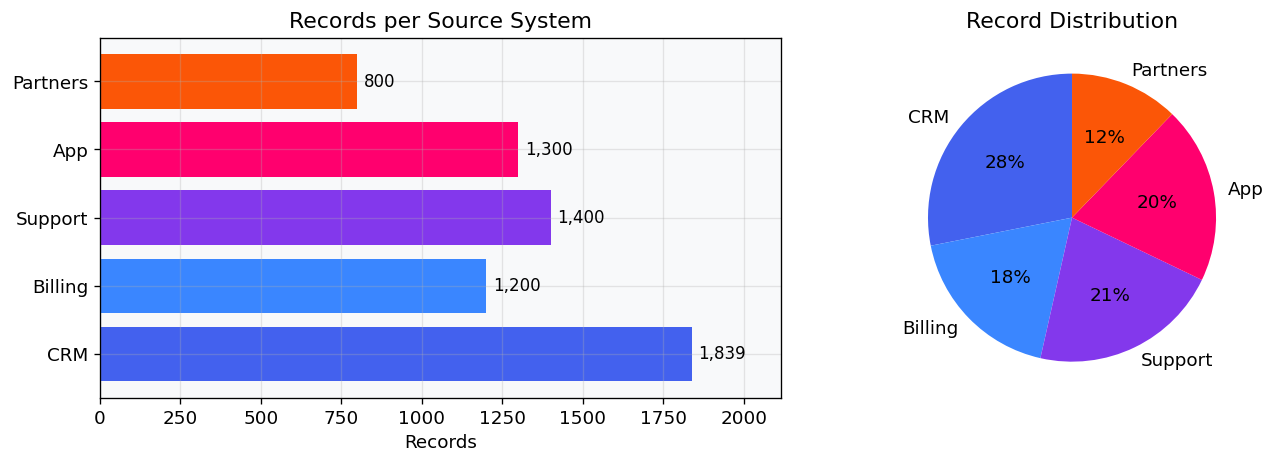

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar chart: records per source
ax = axes[0]
bars = ax.barh(summary.index, summary["Records"], color=COLORS)
ax.set_xlabel("Records")
ax.set_title("Records per Source System")
for bar, val in zip(bars, summary["Records"]):
    ax.text(bar.get_width() + 20, bar.get_y() + bar.get_height()/2,
            f"{val:,}", va="center", fontsize=10)
ax.set_xlim(0, summary["Records"].max() * 1.15)

# Pie chart: share
ax = axes[1]
ax.pie(summary["Records"], labels=summary.index, autopct="%1.0f%%",
       colors=COLORS, startangle=90)
ax.set_title("Record Distribution")

plt.tight_layout()
plt.show()

### Data Quality: Field Completeness

The 4 key identity fields - `email`, `phone`, `first_name`, `last_name` - have very different completeness across sources. This is *the* core challenge: no single field is reliable everywhere.

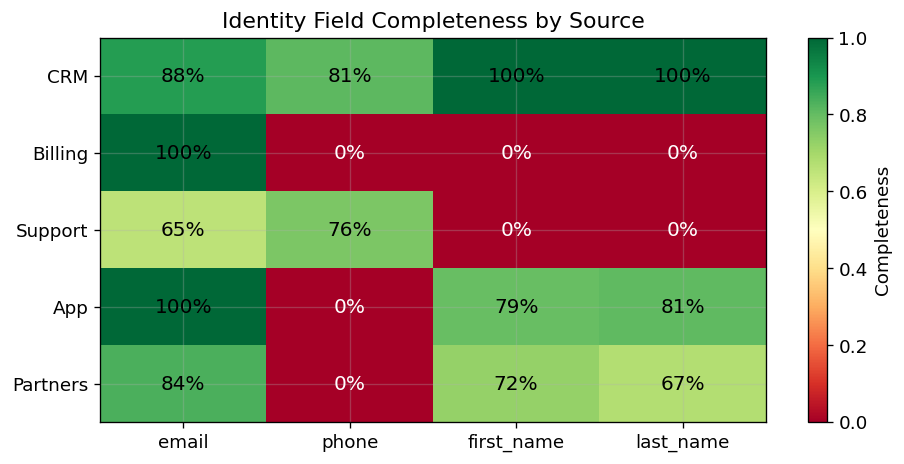

Key observations:
  - Phone is missing from Billing, App, and Partners entirely
  - Support has ~30% email coverage
  - App/Partners have sparse names
  → No single field can match across all sources. We need probabilistic matching.


In [4]:
# Check completeness of the 4 key identity fields
identity_fields = ["email", "phone", "first_name", "last_name"]

def completeness(df, fields):
    result = {}
    for f in fields:
        if f in df.columns:
            non_null = df[f].notna() & (df[f].astype(str).str.strip() != "")
            result[f] = non_null.mean()
        else:
            result[f] = 0.0
    return result

completeness_data = pd.DataFrame({
    name: completeness(df, identity_fields)
    for name, df in source_frames.items()
}).T

# Heatmap
fig, ax = plt.subplots(figsize=(8, 4))
im = ax.imshow(completeness_data.values, cmap="RdYlGn", aspect="auto", vmin=0, vmax=1)
ax.set_xticks(range(len(identity_fields)))
ax.set_xticklabels(identity_fields)
ax.set_yticks(range(len(completeness_data)))
ax.set_yticklabels(completeness_data.index)
for i in range(len(completeness_data)):
    for j in range(len(identity_fields)):
        val = completeness_data.iloc[i, j]
        color = "white" if val < 0.5 else "black"
        ax.text(j, i, f"{val:.0%}", ha="center", va="center", fontsize=12, color=color)
plt.colorbar(im, ax=ax, label="Completeness")
ax.set_title("Identity Field Completeness by Source")
plt.tight_layout()
plt.show()

print("Key observations:")
print("  - Phone is missing from Billing, App, and Partners entirely")
print("  - Support has ~30% email coverage")
print("  - App/Partners have sparse names")
print("  → No single field can match across all sources. We need probabilistic matching.")

### Data Quality: Format Inconsistencies

Even when the same person appears in multiple systems, the data looks different. Names are in different cases, phones have different formats, and some sources use `display_name` instead of `first_name`/`last_name`.

In [5]:
# Show format inconsistencies across sources
examples = pd.DataFrame([
    {"Field": "Name (CRM)",     "Example": crm.iloc[0][["first_name", "last_name"]].to_dict()},
    {"Field": "Name (Billing)",  "Example": billing_raw.iloc[0][["account_name"]].to_dict()},
    {"Field": "Name (Support)",  "Example": support_raw.iloc[0][["display_name"]].to_dict()},
    {"Field": "Name (App)",      "Example": app.iloc[0][["first_name", "last_name"]].to_dict()},
    {"Field": "Phone (CRM)",     "Example": crm[crm.phone.notna()].iloc[0]["phone"]},
    {"Field": "Phone (Support)", "Example": support_raw[support_raw.phone.notna()].iloc[0]["phone"]},
])
print("Name and phone formats vary wildly across sources:\n")
for _, row in examples.iterrows():
    print(f"  {row['Field']:<20s} → {row['Example']}")

# Case variation in names
print("\nCase inconsistencies in App signups:")
app_names = app[app.first_name.notna() & (app.first_name != "")]
upper_pct = (app_names.first_name.str.isupper().sum() / len(app_names) * 100)
lower_pct = (app_names.first_name.str.islower().sum() / len(app_names) * 100)
title_pct = (app_names.first_name.str.istitle().sum() / len(app_names) * 100)
print(f"  UPPERCASE: {upper_pct:.0f}%  |  lowercase: {lower_pct:.0f}%  |  Title Case: {title_pct:.0f}%")

Name and phone formats vary wildly across sources:

  Name (CRM)           → {'first_name': 'Betty', 'last_name': 'Baker'}
  Name (Billing)       → {'account_name': 'Victoria Cook'}
  Name (Support)       → {'display_name': 'CHRISTINA BROWN'}
  Name (App)           → {'first_name': nan, 'last_name': 'HOWARD'}
  Phone (CRM)          → 650-650-6176
  Phone (Support)      → 617-689-9311

Case inconsistencies in App signups:
  UPPERCASE: 15%  |  lowercase: 10%  |  Title Case: 78%


### Cross-Source Overlap

How many emails appear in more than one system? This gives us a lower bound on the number of entities that *should* be merged.

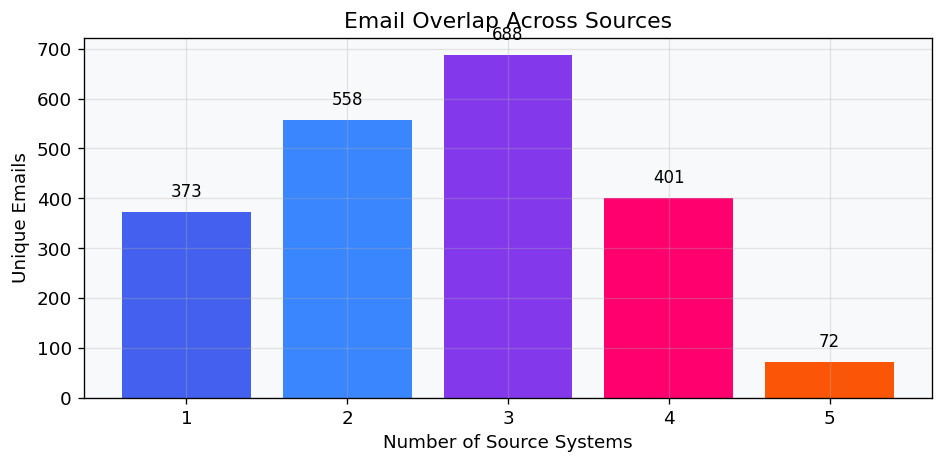

Emails appearing in 2+ sources: 1,719 (these are definite duplicates)
Emails in only 1 source: 373

But email alone won't catch everything - some records share only phone or name.


In [6]:
# Collect emails from each source
email_sources = {}
source_email_cols = {
    "CRM": (crm, "email"), "Billing": (billing_raw, "email"),
    "Support": (support_raw, "email"), "App": (app, "email"),
    "Partners": (partners_raw, "email"),
}
for sname, (df, col) in source_email_cols.items():
    emails = df[col].dropna().str.lower().str.strip()
    emails = emails[emails != ""]
    for e in emails:
        email_sources.setdefault(e, set()).add(sname)

overlap_counts = pd.Series([len(v) for v in email_sources.values()]).value_counts().sort_index()

fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.bar(overlap_counts.index.astype(str), overlap_counts.values, color=COLORS[:len(overlap_counts)])
ax.set_xlabel("Number of Source Systems")
ax.set_ylabel("Unique Emails")
ax.set_title("Email Overlap Across Sources")
for bar, val in zip(bars, overlap_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 30,
            f"{val:,}", ha="center", fontsize=10)
plt.tight_layout()
plt.show()

multi = sum(1 for v in email_sources.values() if len(v) > 1)
print(f"Emails appearing in 2+ sources: {multi:,} (these are definite duplicates)")
print(f"Emails in only 1 source: {overlap_counts.get(1, 0):,}")
print(f"\nBut email alone won't catch everything - some records share only phone or name.")

### The Combinatorial Challenge

Naive pairwise comparison of 6,539 records = **21.4 million pairs**. That's why blocking is essential.

In [7]:
n = summary["Records"].sum()
naive_pairs = n * (n - 1) // 2
print(f"Records:        {n:>10,}")
print(f"Naive pairs:    {naive_pairs:>10,}")
print(f"\nWith blocking (email + phone + name + company), we reduce this")
print(f"to roughly ~50K-100K candidate pairs - a 200x reduction.")

Records:             6,539
Naive pairs:    21,375,991

With blocking (email + phone + name + company), we reduce this
to roughly ~50K-100K candidate pairs - a 200x reduction.


### Prepare Sources for Reconciliation

Raw data has format differences (Billing uses `account_name`, Support uses `display_name`). In production, dbt staging models handle this. Here we do it in pandas.

In [8]:
# Billing: parse "account_name" → first_name + last_name
billing = billing_raw.copy()
name_parts = billing["account_name"].str.split(" ", n=1, expand=True)
billing["first_name"] = name_parts[0]
billing["last_name"] = name_parts[1].fillna("")
# Handle "Last, First" format
comma_mask = billing["first_name"].str.endswith(",")
billing.loc[comma_mask, "first_name"], billing.loc[comma_mask, "last_name"] = (
    billing.loc[comma_mask, "last_name"],
    billing.loc[comma_mask, "first_name"].str.rstrip(","),
)

# Support: split "display_name" → first_name + last_name, rename company
support = support_raw.copy()
name_parts = support["display_name"].str.strip().str.split(" ", n=1, expand=True)
support["first_name"] = name_parts[0].str.title()
support["last_name"] = name_parts[1].fillna("").str.title()
support["company_name"] = support["company"]

# App: fill nulls
app["first_name"] = app["first_name"].fillna("")
app["last_name"] = app["last_name"].fillna("")

# Partners: rename company, fill nulls
partners = partners_raw.copy()
partners["company_name"] = partners["company"].fillna("")
partners["first_name"] = partners["first_name"].fillna("")
partners["last_name"] = partners["last_name"].fillna("")
partners["email"] = partners["email"].fillna("")

print("Sources prepared. Name parsing and field alignment complete.")

Sources prepared. Name parsing and field alignment complete.


---
## Part 2 - The Kanoniv Spec

Everything about how records are matched, scored, and merged is defined in a single YAML file. Let's load it and walk through each section.

In [9]:
from kanoniv import Spec

spec = Spec.from_file("kanoniv.yml")

print(f"API version:      {spec.parsed['api_version']}")
print(f"Entity:           {spec.parsed['entity']['name']}")
print(f"Identity version: {spec.parsed['identity_version']}")
print(f"Sources:          {len(spec.sources)}")
print(f"Owner:            {spec.parsed['metadata']['owner']}")

API version:      kanoniv/v2
Entity:           customer
Identity version: customer_v1
Sources:          5
Owner:            data-engineering


### Sources & Schema

Each source declares its primary key, field schema (types + PII flags), attribute mappings, freshness constraints, and tags.

In [10]:
sources_info = []
for s in spec.sources:  # .sources normalizes map-style YAML → list of dicts
    schema = s.get("schema", {})
    schema_fields = list(schema.keys()) if isinstance(schema, dict) else []
    pii_fields = [k for k, v in schema.items() if isinstance(v, dict) and v.get("pii")] if isinstance(schema, dict) else []
    freshness = s.get("freshness", {})
    tags = s.get("tags", [])
    sources_info.append({
        "Source": s.get("name", ""),
        "Primary Key": s.get("primary_key", "-"),
        "Schema Fields": len(schema_fields),
        "PII Fields": len(pii_fields),
        "Freshness": freshness.get("max_age", "-") if isinstance(freshness, dict) else "-",
        "Tags": ", ".join(tags) if isinstance(tags, list) else "-",
    })

pd.DataFrame(sources_info).set_index("Source")

,Primary Key,Schema Fields,PII Fields,Freshness,Tags
Source,,,,,
app_signups,app_user_id,3,3,24h,"production, app"
billing_accounts,billing_account_id,4,3,24h,"production, billing"
crm_contacts,crm_contact_id,5,4,24h,"production, crm"
partner_leads,partner_lead_id,4,3,72h,"production, partner"
support_users,support_user_id,5,4,48h,"production, support"


### Blocking Strategy

Blocking reduces the O(n²) comparison space by only comparing records that share at least one blocking key. Multiple keys = union of candidates.

In [11]:
blocking = spec.parsed["blocking"]
print(f"Strategy: {blocking['strategy']}")
print(f"Blocking keys ({len(blocking['keys'])}):")
for i, key in enumerate(blocking["keys"], 1):
    print(f"  {i}. {key}")

print(f"\nA pair is compared if they share ANY one of these keys.")
print(f"This means even if two records don't share an email,")
print(f"they'll still be compared if they share [last_name, first_name].")

Strategy: composite
Blocking keys (4):
  1. ['email']
  2. ['phone']
  3. ['last_name', 'first_name']
  4. ['company_name', 'last_name']

A pair is compared if they share ANY one of these keys.
This means even if two records don't share an email,
they'll still be compared if they share [last_name, first_name].


### Fellegi-Sunter Probabilistic Scoring

Each field gets two probabilities:
- **m** = P(fields agree | true match) - how often do real matches agree on this field?
- **u** = P(fields agree | non-match) - how often do random pairs agree by chance?

The log-likelihood ratio `log₂(m/u)` determines how much weight each field agreement carries.

In [12]:
scoring = spec.parsed["decision"]["scoring"]
fields = scoring["fields"]

# Build a DataFrame of field configurations
fs_config = pd.DataFrame(fields)
fs_config["log_lr_agree"] = np.log2(fs_config["m_probability"] / fs_config["u_probability"])
fs_config["log_lr_disagree"] = np.log2((1 - fs_config["m_probability"]) / (1 - fs_config["u_probability"]))
fs_config["weighted_agree"] = fs_config["log_lr_agree"] * fs_config["weight"]

display_cols = ["name", "comparator", "normalizer", "m_probability", "u_probability",
                "weight", "log_lr_agree", "weighted_agree"]
fs_config[display_cols].round(2)

,name,comparator,normalizer,m_probability,u_probability,weight,log_lr_agree,weighted_agree
0,email,exact,email,0.95,0.00,2.0,9.89,19.78
1,phone,exact,phone,0.85,0.00,1.5,7.41,11.11
2,first_name,jaro_winkler,nickname,0.85,0.05,1.0,4.09,4.09
3,last_name,jaro_winkler,name,0.88,0.02,1.0,5.46,5.46
4,company_name,jaro_winkler,generic,0.80,0.02,1.0,5.32,5.32


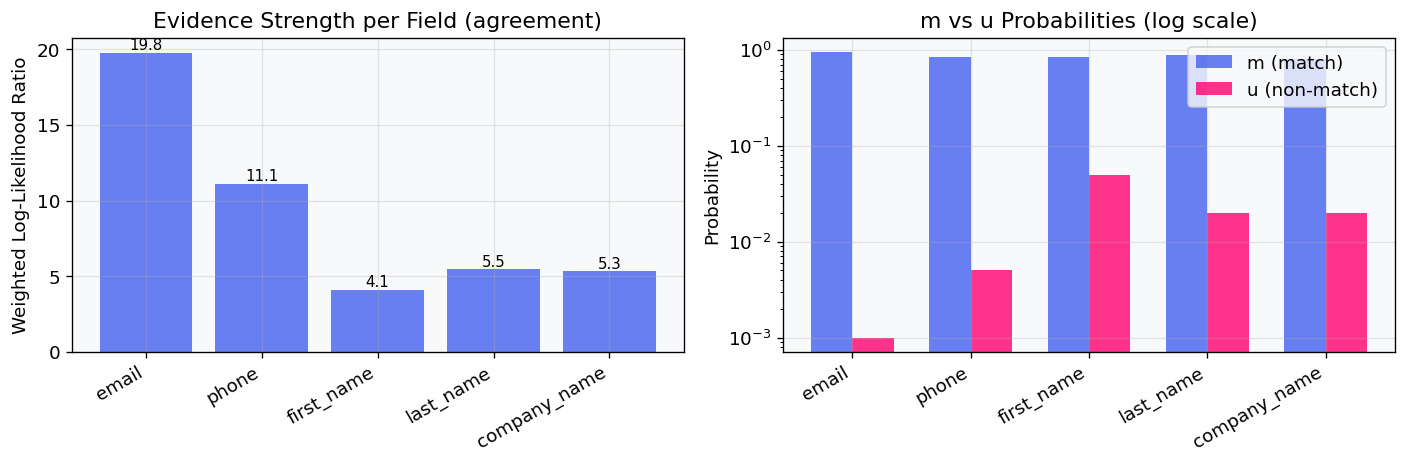

Maximum possible composite score (all fields agree): 45.8
Match threshold: 8.0  |  Review threshold: 4.0


In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: log-likelihood ratios
ax = axes[0]
x = range(len(fs_config))
agree_bars = ax.bar(x, fs_config["weighted_agree"], color=COLORS[0], alpha=0.8, label="Agree (weighted)")
ax.set_xticks(x)
ax.set_xticklabels(fs_config["name"], rotation=30, ha="right")
ax.set_ylabel("Weighted Log-Likelihood Ratio")
ax.set_title("Evidence Strength per Field (agreement)")
ax.axhline(0, color="black", linewidth=0.5)
for bar, val in zip(agree_bars, fs_config["weighted_agree"]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
            f"{val:.1f}", ha="center", fontsize=9)

# Right: m vs u probabilities
ax = axes[1]
width = 0.35
ax.bar([i - width/2 for i in x], fs_config["m_probability"], width,
       label="m (match)", color=COLORS[0], alpha=0.8)
ax.bar([i + width/2 for i in x], fs_config["u_probability"], width,
       label="u (non-match)", color=COLORS[3], alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(fs_config["name"], rotation=30, ha="right")
ax.set_ylabel("Probability")
ax.set_yscale("log")
ax.set_title("m vs u Probabilities (log scale)")
ax.legend()

plt.tight_layout()
plt.show()

max_score = fs_config["weighted_agree"].sum()
thresholds = scoring["thresholds"]
print(f"Maximum possible composite score (all fields agree): {max_score:.1f}")
print(f"Match threshold: {thresholds['match']}  |  Review threshold: {thresholds['possible']}")

### Normalizers

Before comparing fields, Kanoniv normalizes them to handle format differences:

| Normalizer | What it does |
|------------|-------------|
| `email` | Lowercase, strip Gmail dot trick, strip plus-addressing |
| `phone` | Strip formatting → E.164 (+1XXXXXXXXXX) |
| `nickname` | NFC + lowercase + canonical nickname mapping (Bob→Robert, Liz→Elizabeth, 70+ mappings) |
| `name` | Unicode NFC, lowercase, whitespace collapse |
| `generic` | Trim + lowercase |

In [14]:
normalizer_examples = pd.DataFrame([
    {"Normalizer": "email",    "Input": "John.Doe+promo@gmail.com",  "Output": "johndoe@gmail.com"},
    {"Normalizer": "phone",    "Input": "(617) 689-9311",           "Output": "+16176899311"},
    {"Normalizer": "nickname", "Input": "Bob",                      "Output": "robert"},
    {"Normalizer": "nickname", "Input": "Liz",                      "Output": "elizabeth"},
    {"Normalizer": "name",     "Input": "  O'BRIEN  ",             "Output": "o'brien"},
    {"Normalizer": "generic",  "Input": "  ACME Corp  ",           "Output": "acme corp"},
])
normalizer_examples

,Normalizer,Input,Output
0,email,John.Doe+promo@gmail.com,johndoe@gmail.com
1,phone,(617) 689-9311,+16176899311
2,nickname,Bob,robert
3,nickname,Liz,elizabeth
4,name,O'BRIEN,o'brien
5,generic,ACME Corp,acme corp


### EM Training with Random u-Estimation

Kanoniv uses a two-phase training approach:

1. **Phase 1** - Estimate u-probabilities from **random (unblocked)** pairs. This avoids the bias where blocked pairs always agree on the blocking field, which would inflate u for email/phone.

2. **Phase 2** - EM with `fix_u=true` - only learns m-probabilities from blocked candidate pairs, keeping u frozen from Phase 1.

In [15]:
training = scoring["training"]
training_info = pd.DataFrame([{
    "Method": training["method"].upper(),
    "u-Estimation": training["estimate_u"],
    "Max Random Pairs": f"{training['max_random_pairs']:,}",
    "Max EM Iterations": training["max_iterations"],
    "Convergence": training["convergence_threshold"],
}])
training_info.T

,0
Method,EM
u-Estimation,random_sampling
Max Random Pairs,"1,000,000"
Max EM Iterations,25
Convergence,0.001


### Survivorship Rules

When multiple source records merge into one golden record, which value "wins"?

- **Default:** `source_priority` - CRM is system of record
- **Per-field overrides:** email/first_name/last_name use `most_complete`, phone prefers CRM then Support

In [16]:
surv = spec.parsed["survivorship"]
print(f"Default strategy: {surv['default']}\n")

overrides_data = []
for o in surv["overrides"]:
    priority = o.get("priority", None)
    overrides_data.append({
        "field": o["field"],
        "strategy": o["strategy"],
        "priority": " → ".join(priority) if isinstance(priority, list) else "-",
    })
pd.DataFrame(overrides_data)

Default strategy: source_priority



,field,strategy,priority
0,email,most_complete,-
1,phone,source_priority,crm_contacts → support_users
2,first_name,most_complete,-
3,last_name,most_complete,-
4,company_name,source_priority,crm_contacts → billing_accounts → partner_leads


### Governance & Compliance

Operational guardrails built into the spec - these prevent silent data quality degradation.

In [17]:
gov = spec.parsed["governance"]
entity_compliance = spec.parsed["entity"].get("compliance", {})

governance_info = pd.DataFrame([
    {"Setting": "Require freshness", "Value": gov.get("require_freshness")},
    {"Setting": "Require schema", "Value": gov.get("require_schema")},
    {"Setting": "Required tags", "Value": str(gov.get("required_tags"))},
    {"Setting": "Log probabilities", "Value": gov.get("log_probabilities")},
    {"Setting": "Shadow on threshold change", "Value": gov.get("require_shadow_on_threshold_change")},
    {"Setting": "Compliance frameworks", "Value": str(entity_compliance.get("frameworks"))},
    {"Setting": "PII fields", "Value": str(entity_compliance.get("pii_fields"))},
    {"Setting": "Audit required", "Value": entity_compliance.get("audit_required")},
]).set_index("Setting")

governance_info

,Value
Setting,
Require freshness,True
Require schema,True
Required tags,['production']
Log probabilities,True
Shadow on threshold change,True
Compliance frameworks,['gdpr']
PII fields,"['email', 'phone', 'first_name', 'last_name']"
Audit required,True


---
## Part 3 - Validation & Execution Plan

Before running reconciliation, validate the spec and inspect the compiled execution plan.

In [18]:
from kanoniv import validate

result = validate(spec)
print(result)
print("\nSpec is valid - no schema errors, no semantic warnings.")

<ValidationResult: Valid>

Spec is valid - no schema errors, no semantic warnings.


In [19]:
from kanoniv import plan

p = plan(spec)
print(p)

  Identity:     customer (customer_v1)
  Sources:      0 ()
  Signals:      
  Blocking:     unknown, unknown, unknown, unknown
  Thresholds:   merge >= 0.9, review >= 0.7
  Stages:       8 execution stages
  Survivorship: 0 fields configured
  Risk flags:   0 critical, 0 high, 1 medium
  Plan hash:    sha256:cf47b372...


---
## Part 4 - Reconciliation

Feed all 5 prepared sources into the Rust engine. The engine runs entirely locally via PyO3 - no cloud API, no network calls.

**Under the hood:**
1. Estimate u-probabilities from ~1M random pairs
2. EM training (up to 25 iterations) to learn m-probabilities
3. Block → compare → score all candidate pairs
4. Cluster matches via union-find
5. Assemble golden records using survivorship rules

In [20]:
from kanoniv import Source, reconcile

sources = [
    Source.from_pandas("crm_contacts", crm, primary_key="crm_contact_id"),
    Source.from_pandas("billing_accounts", billing, primary_key="billing_account_id"),
    Source.from_pandas("support_users", support, primary_key="support_user_id"),
    Source.from_pandas("app_signups", app, primary_key="app_user_id"),
    Source.from_pandas("partner_leads", partners, primary_key="partner_lead_id"),
]

# Show entity counts per source
entity_counts = pd.DataFrame([
    {"Source": s.name, "Entities": len(s.to_entities("customer"))}
    for s in sources
]).set_index("Source")
print(f"Total input entities: {entity_counts['Entities'].sum():,}\n")
print(entity_counts.to_string())

Total input entities: 6,539

                  Entities
Source                    
crm_contacts          1839
billing_accounts      1200
support_users         1400
app_signups           1300
partner_leads          800


In [21]:
import time

t0 = time.perf_counter()
result = reconcile(sources, spec)
elapsed = time.perf_counter() - t0

total_input = sum(len(s.to_entities("customer")) for s in sources)

print(f"Reconciliation complete in {elapsed:.2f}s\n")
print(f"Input records:  {total_input:>6,}")
print(f"Golden records: {result.cluster_count:>6,}")
print(f"Merge rate:     {result.merge_rate:>6.1%}")
print(f"Compression:    {total_input / result.cluster_count:>6.1f}x")

Reconciliation complete in 0.42s

Input records:   6,539
Golden records:  2,443
Merge rate:      62.6%
Compression:       2.7x


### Engine Telemetry

The engine returns telemetry about the matching process - EM convergence, trained probabilities, comparison stats.

In [22]:
telemetry = result.telemetry

# Display available telemetry keys
print("Telemetry keys:")
for key in sorted(telemetry.keys()):
    val = telemetry[key]
    if isinstance(val, (dict, list)):
        print(f"  {key}: ({type(val).__name__}, {len(val)} items)")
    else:
        print(f"  {key}: {val}")

Telemetry keys:
  blocking_groups: 8543
  decisions_by_type: (dict, 3 items)
  pairs_evaluated: 28674
  rule_telemetry: (list, 5 items)


---
## Part 5 - Analyzing Golden Records

Each golden record represents one real-world customer, assembled from the best data across all sources.

In [23]:
df = result.to_pandas()
df["member_count"] = df["member_count"].astype(int)

print(f"Golden records: {len(df):,} rows × {df.shape[1]} columns\n")
print("Columns:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2d}. {col}", end="\n" if i % 3 == 0 else "\t")
print()

Golden records: 2,443 rows × 34 columns

Columns:
   1. company_name	   2. created_at	   3. crm_contact_id
   4. display_name	   5. email	   6. first_name
   7. is_active	   8. kanoniv_id	   9. last_name
  10. last_seen_at	  11. lead_source	  12. member_count
  13. phone	  14. support_user_id	  15. title
  16. updated_at	  17. account_name	  18. app_user_id
  19. billing_account_id	  20. billing_address	  21. device_type
  22. estimated_arr	  23. is_verified	  24. last_login_at
  25. mrr_cents	  26. os	  27. partner_lead_id
  28. partner_name	  29. payment_method	  30. plan
  31. signup_source	  32. stage	  33. status
  34. submitted_at	


In [24]:
# Show a sample of golden records - key identity fields + source IDs
display_cols = ["kanoniv_id", "member_count", "first_name", "last_name", "email",
                "crm_contact_id", "billing_account_id", "support_user_id",
                "app_user_id", "partner_lead_id"]
df.sort_values("member_count", ascending=False)[display_cols].head(10)

,kanoniv_id,member_count,first_name,last_name,email,crm_contact_id,billing_account_id,support_user_id,app_user_id,partner_lead_id
463,knv_0606b586b97e,22,Samantha,,,NaN,NaN,NaN,NaN,PTR_000748
1074,knv_a728dec36995,16,Elizabeth,Brookks,kevin.brooks29@outlook.com,CRM_001342,BILL_001107,SUP_000355,APP_001122,PTR_000682
561,knv_dd263e1637e4,11,oJnathan,hernandez,jonathan.hernandez11@protonmail.com,CRM_001221,BILL_000401,SUP_000515,APP_001243,PTR_000487
675,knv_80eec01c116e,10,jennifer,Bailey,jennifer.bailey@sterling.co,CRM_001683,BILL_000820,SUP_001255,APP_000450,PTR_000351
25,knv_c60a9b3d7201,9,brenda,rGeen,daniel.green@prism.com,CRM_001229,BILL_000564,SUP_001009,APP_000806,PTR_000565
1023,knv_6b3ddb565d74,9,betty,james,betty.james@databridge.com,CRM_001811,BILL_000598,SUP_001154,APP_000318,NaN
1,knv_6dd926260fd5,9,Anndrea,Williams,steven.williams@cloudpeak.com,CRM_000409,BILL_001083,SUP_001116,APP_001088,PTR_000637
251,knv_2fc90a1ea19e,9,Benjamin,Wood,charles.wood12@fastmail.com,CRM_001827,BILL_000959,SUP_001306,NaN,PTR_000753
730,knv_0651a5cccf1b,9,Vlizabeth,Scott,elizabeth.scott55@gmail.com,CRM_001813,BILL_000395,SUP_001064,APP_000361,NaN
12,knv_4d145c84a993,8,JJoshua,Rivera,donna.rivera@keystone.com,CRM_000629,BILL_000353,SUP_000665,APP_001092,PTR_000265


### Cluster Size Distribution

How many source records were merged into each golden record?

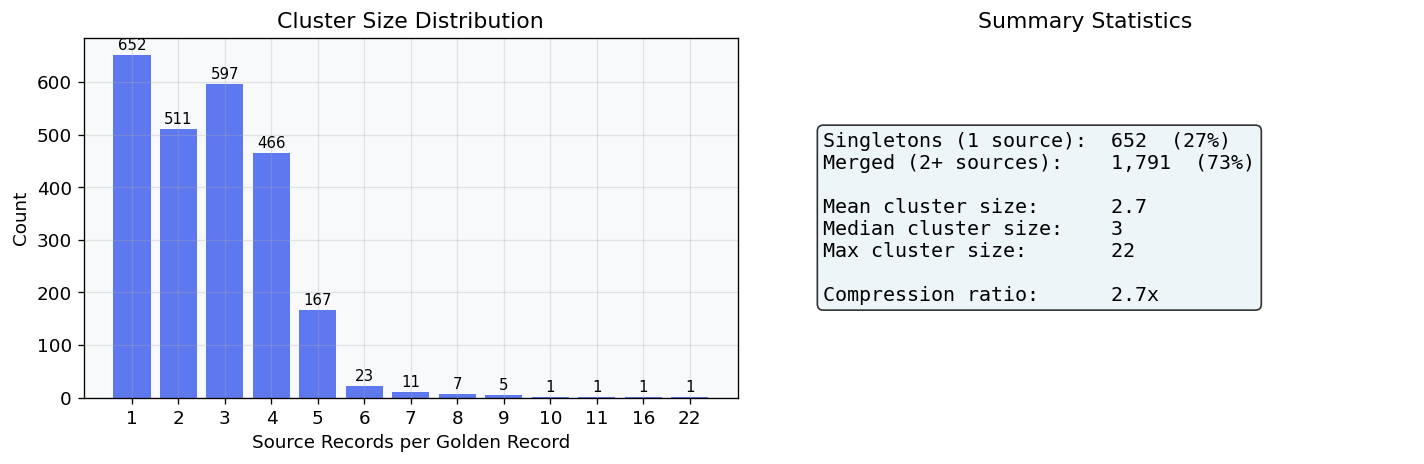

In [25]:
cluster_dist = df["member_count"].value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
ax = axes[0]
bars = ax.bar(cluster_dist.index.astype(str), cluster_dist.values, color=COLORS[0], alpha=0.85)
ax.set_xlabel("Source Records per Golden Record")
ax.set_ylabel("Count")
ax.set_title("Cluster Size Distribution")
for bar, val in zip(bars, cluster_dist.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
            f"{val:,}", ha="center", fontsize=9)

# Summary stats
ax = axes[1]
ax.axis("off")
singletons = (df["member_count"] == 1).sum()
merged = (df["member_count"] >= 2).sum()
stats_text = (
    f"Singletons (1 source):  {singletons:,}  ({singletons/len(df):.0%})\n"
    f"Merged (2+ sources):    {merged:,}  ({merged/len(df):.0%})\n"
    f"\n"
    f"Mean cluster size:      {df['member_count'].mean():.1f}\n"
    f"Median cluster size:    {df['member_count'].median():.0f}\n"
    f"Max cluster size:       {df['member_count'].max()}\n"
    f"\n"
    f"Compression ratio:      {total_input / len(df):.1f}x"
)
ax.text(0.1, 0.5, stats_text, transform=ax.transAxes, fontsize=12,
        verticalalignment="center", fontfamily="monospace",
        bbox=dict(boxstyle="round", facecolor="#e8f4f8", alpha=0.8))
ax.set_title("Summary Statistics")

plt.tight_layout()
plt.show()

### Source Coverage per Golden Record

Which sources contribute to each golden record? This shows how well the matching works across systems.

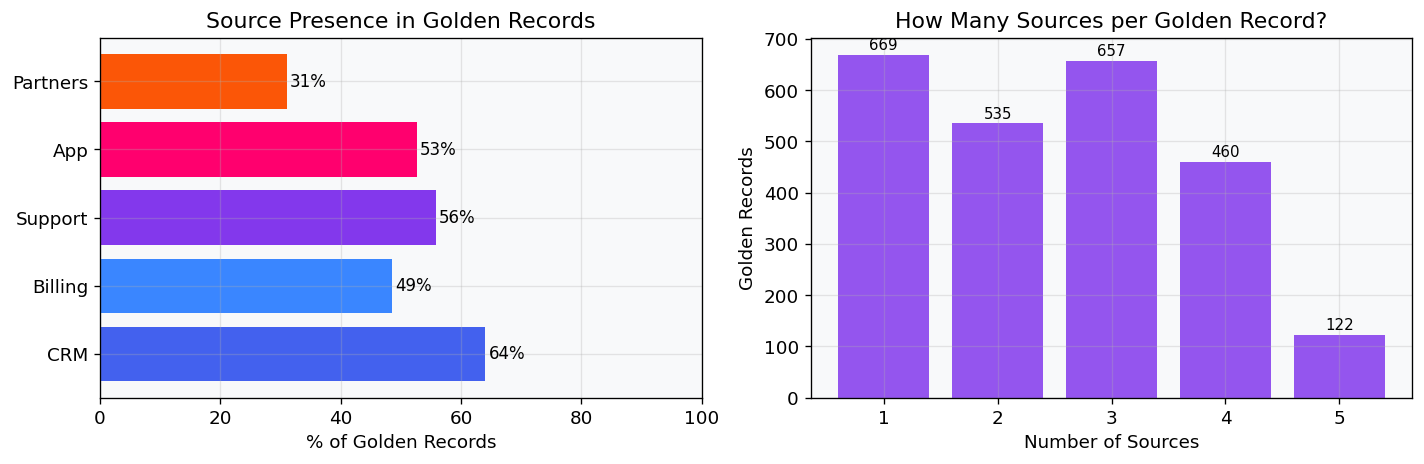

In [26]:
source_id_cols = {
    "CRM": "crm_contact_id",
    "Billing": "billing_account_id",
    "Support": "support_user_id",
    "App": "app_user_id",
    "Partners": "partner_lead_id",
}

# Count how many golden records have each source present
coverage = pd.DataFrame({
    src: df[col].notna() & (df[col] != "") for src, col in source_id_cols.items()
})
coverage_pct = coverage.mean()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar chart: source presence in golden records
ax = axes[0]
bars = ax.barh(coverage_pct.index, coverage_pct.values * 100, color=COLORS)
ax.set_xlabel("% of Golden Records")
ax.set_title("Source Presence in Golden Records")
for bar, val in zip(bars, coverage_pct.values):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
            f"{val:.0%}", va="center", fontsize=10)
ax.set_xlim(0, 100)

# Stacked bar: source combinations for merged records
ax = axes[1]
sources_per_entity = coverage.sum(axis=1)
source_count_dist = sources_per_entity.value_counts().sort_index()
ax.bar(source_count_dist.index.astype(str), source_count_dist.values, color=COLORS[2], alpha=0.85)
ax.set_xlabel("Number of Sources")
ax.set_ylabel("Golden Records")
ax.set_title("How Many Sources per Golden Record?")
for i, (idx, val) in enumerate(source_count_dist.items()):
    ax.text(i, val + 10, f"{val:,}", ha="center", fontsize=9)

plt.tight_layout()
plt.show()

### Field Completeness: Before vs After

How much did survivorship rules improve field completeness?

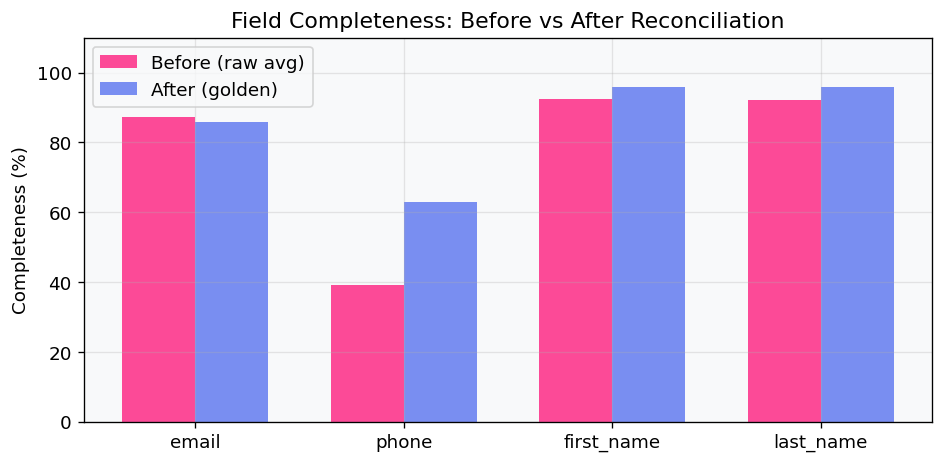

            Before (raw avg)  After (golden)  Improvement
email                  0.873           0.858       -0.015
phone                  0.391           0.628        0.237
first_name             0.925           0.959        0.034
last_name              0.922           0.959        0.037


In [27]:
# Before: average completeness across all source records
all_sources_concat = pd.concat([
    crm[["email", "phone", "first_name", "last_name"]],
    billing[["email", "first_name", "last_name"]].assign(phone=np.nan),
    support[["email", "phone", "first_name", "last_name"]],
    app[["email", "first_name", "last_name"]].assign(phone=np.nan),
    partners[["email", "first_name", "last_name"]].assign(phone=np.nan),
], ignore_index=True)

before = {}
after = {}
for field in ["email", "phone", "first_name", "last_name"]:
    before[field] = (all_sources_concat[field].notna() &
                     (all_sources_concat[field].astype(str).str.strip() != "")).mean()
    if field in df.columns:
        after[field] = (df[field].notna() & (df[field].astype(str).str.strip() != "")).mean()
    else:
        after[field] = 0.0

compare = pd.DataFrame({"Before (raw avg)": before, "After (golden)": after})
compare["Improvement"] = compare["After (golden)"] - compare["Before (raw avg)"]

fig, ax = plt.subplots(figsize=(8, 4))
x = range(len(compare))
width = 0.35
ax.bar([i - width/2 for i in x], compare["Before (raw avg)"] * 100, width,
       label="Before (raw avg)", color=COLORS[3], alpha=0.7)
ax.bar([i + width/2 for i in x], compare["After (golden)"] * 100, width,
       label="After (golden)", color=COLORS[0], alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(compare.index)
ax.set_ylabel("Completeness (%)")
ax.set_title("Field Completeness: Before vs After Reconciliation")
ax.legend()
ax.set_ylim(0, 110)
plt.tight_layout()
plt.show()

print(compare.round(3).to_string())

---
## Part 6 - Lineage & Traceability

Every golden record gets a deterministic **Kanoniv ID** (`knv_...`) - a stable identifier derived from the member records. The same inputs always produce the same ID.

In [28]:
# Show Kanoniv IDs for the largest clusters
largest = df.nlargest(5, "member_count")
print("Top 5 largest golden records:\n")
for _, row in largest.iterrows():
    print(f"  {row['kanoniv_id']}  ({row['member_count']} sources)")
    print(f"    Name:    {row.get('first_name', '')} {row.get('last_name', '')}")
    print(f"    Email:   {row.get('email', '')}")
    sources_present = [src for src, col in source_id_cols.items()
                       if pd.notna(row.get(col)) and row.get(col) != ""]
    print(f"    Sources: {', '.join(sources_present)}")
    print()

Top 5 largest golden records:

  knv_0606b586b97e  (22 sources)
    Name:    Samantha 
    Email:   
    Sources: Partners

  knv_a728dec36995  (16 sources)
    Name:    Elizabeth Brookks
    Email:   kevin.brooks29@outlook.com
    Sources: CRM, Billing, Support, App, Partners

  knv_dd263e1637e4  (11 sources)
    Name:    oJnathan hernandez
    Email:   jonathan.hernandez11@protonmail.com
    Sources: CRM, Billing, Support, App, Partners

  knv_80eec01c116e  (10 sources)
    Name:    jennifer Bailey
    Email:   jennifer.bailey@sterling.co
    Sources: CRM, Billing, Support, App, Partners

  knv_6dd926260fd5  (9 sources)
    Name:    Anndrea Williams
    Email:   steven.williams@cloudpeak.com
    Sources: CRM, Billing, Support, App, Partners



In [29]:
# Deep dive: trace one entity back to its source records
example = df[df["member_count"] >= 4].iloc[0]
print(f"Tracing Kanoniv ID: {example['kanoniv_id']}")
print(f"Golden record: {example.get('first_name', '')} {example.get('last_name', '')} <{example.get('email', '')}>")
print(f"Member count: {example['member_count']}\n")

# Find the original source records
source_lookups = [
    ("CRM",      crm,      "crm_contact_id"),
    ("Billing",   billing,  "billing_account_id"),
    ("Support",   support,  "support_user_id"),
    ("App",       app,      "app_user_id"),
    ("Partners",  partners, "partner_lead_id"),
]

traces = []
for src_name, src_df, pk in source_lookups:
    src_id = example.get(pk)
    if pd.notna(src_id) and src_id != "":
        match = src_df[src_df[pk] == src_id]
        if not match.empty:
            row = match.iloc[0]
            traces.append({
                "Source": src_name,
                "ID": src_id,
                "first_name": row.get("first_name", ""),
                "last_name": row.get("last_name", ""),
                "email": row.get("email", ""),
                "phone": row.get("phone", ""),
            })

print("Source records that were merged:")
pd.DataFrame(traces).set_index("Source")

Tracing Kanoniv ID: knv_6dd926260fd5
Golden record: Anndrea Williams <steven.williams@cloudpeak.com>
Member count: 9

Source records that were merged:


,ID,first_name,last_name,email,phone
Source,,,,,
CRM,CRM_000409,Andrea,Williams,andrea.williams65@aol.com,718.460.9524
Billing,BILL_001083,Andrea,Williams,andrea.williams65@aol.com,
Support,SUP_001116,Steven,Williams,NaN,1-303-862-6119
App,APP_001088,Steven,Williams,steven.williams@cloudpeak.com,
Partners,PTR_000637,Andrea,,andrea.williams65@aol.com,


### Cross-Source Match Patterns

Which source pairs merge most frequently? This reveals where the biggest identity fragmentation lies.

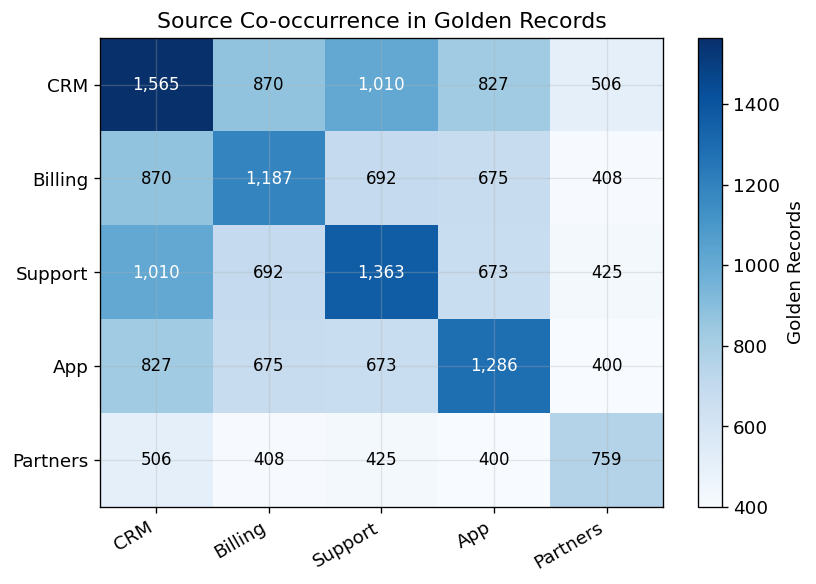

Diagonal = records from that source that appear in any golden record.
Off-diagonal = records from both sources merged into the same entity.


In [30]:
# Build co-occurrence matrix: how often do two sources appear in the same golden record?
source_names = list(source_id_cols.keys())
cooccurrence = pd.DataFrame(0, index=source_names, columns=source_names, dtype=int)

for _, row in df.iterrows():
    present = [src for src, col in source_id_cols.items()
               if pd.notna(row.get(col)) and row.get(col) != ""]
    for i, s1 in enumerate(present):
        for s2 in present[i:]:
            cooccurrence.loc[s1, s2] += 1
            if s1 != s2:
                cooccurrence.loc[s2, s1] += 1

fig, ax = plt.subplots(figsize=(7, 5))
im = ax.imshow(cooccurrence.values, cmap="Blues", aspect="auto")
ax.set_xticks(range(len(source_names)))
ax.set_xticklabels(source_names, rotation=30, ha="right")
ax.set_yticks(range(len(source_names)))
ax.set_yticklabels(source_names)
for i in range(len(source_names)):
    for j in range(len(source_names)):
        val = cooccurrence.iloc[i, j]
        ax.text(j, i, f"{val:,}", ha="center", va="center", fontsize=10,
                color="white" if val > cooccurrence.values.max() * 0.6 else "black")
plt.colorbar(im, ax=ax, label="Golden Records")
ax.set_title("Source Co-occurrence in Golden Records")
plt.tight_layout()
plt.show()

print("Diagonal = records from that source that appear in any golden record.")
print("Off-diagonal = records from both sources merged into the same entity.")

---
## Part 7 - Business Enrichment

The real power of identity resolution: once you have golden records with source IDs, you can join *any* operational data to build a unified customer view. Let's join billing and support data.

---
## Part 6b - Quality Analysis & Spec Tuning Recommendations

Golden records aren't perfect on the first run. Let's inspect the output for signs of **over-merging** (false positives) and **survivorship issues**, then recommend spec tweaks.

In [31]:
# 1. OVER-MERGING: Flag suspiciously large clusters
large_clusters = df[df["member_count"] >= 6].sort_values("member_count", ascending=False)

print(f"Clusters with 6+ members: {len(large_clusters)}")
print(f"These are likely FALSE MERGES - real-world customers rarely exist in 6+ source records.\n")

suspect_cols = ["kanoniv_id", "member_count", "first_name", "last_name", "email", "company_name"]
large_clusters[suspect_cols].head(15)

Clusters with 6+ members: 50
These are likely FALSE MERGES - real-world customers rarely exist in 6+ source records.



,kanoniv_id,member_count,first_name,last_name,email,company_name
463,knv_0606b586b97e,22,Samantha,,,Meridian Partners
1074,knv_a728dec36995,16,Elizabeth,Brookks,kevin.brooks29@outlook.com,Isle Technologies
561,knv_dd263e1637e4,11,oJnathan,hernandez,jonathan.hernandez11@protonmail.com,Quartz Health
675,knv_80eec01c116e,10,jennifer,Bailey,jennifer.bailey@sterling.co,Sterling Ventures
730,knv_0651a5cccf1b,9,Vlizabeth,Scott,elizabeth.scott55@gmail.com,Meridian Partners
1023,knv_6b3ddb565d74,9,betty,james,betty.james@databridge.com,Atlantic Digital
251,knv_2fc90a1ea19e,9,Benjamin,Wood,charles.wood12@fastmail.com,Keystone Data
25,knv_c60a9b3d7201,9,brenda,rGeen,daniel.green@prism.com,Prism Consulting
1,knv_6dd926260fd5,9,Anndrea,Williams,steven.williams@cloudpeak.com,CloudPeak Technologies
12,knv_4d145c84a993,8,JJoshua,Rivera,donna.rivera@keystone.com,Keystone Data


In [32]:
# 2. SURVIVORSHIP ISSUES: Golden records with garbled or typo-ridden names
# The `most_complete` strategy picks the longest non-null value - but that's not always the CLEANEST.

# Find names with suspicious patterns: double capitals, lowercase starts, mixed case junk
name_issues = df[
    (df["first_name"].str.contains(r"^[a-z]", na=False)) |          # lowercase first char
    (df["first_name"].str.contains(r"[A-Z]{2}", na=False)) |        # double uppercase
    (df["last_name"].str.contains(r"^[a-z]", na=False)) |           # lowercase last name
    (df["last_name"].str.contains(r"[A-Z]{2}", na=False))           # double uppercase
].copy()

print(f"Golden records with name quality issues: {len(name_issues)}")
print(f"({len(name_issues)/len(df):.1%} of all golden records)\n")
print("Examples of names that survived with quality issues:\n")
name_issues[["kanoniv_id", "first_name", "last_name", "email", "member_count"]].head(15)

Golden records with name quality issues: 199
(8.1% of all golden records)

Examples of names that survived with quality issues:



,kanoniv_id,first_name,last_name,email,member_count
8,knv_1dc3996563dc,joseph,rogers,joseph.rogers@atlas.co,2
9,knv_8fb28188b603,mark,Rooss,mark.ross@redwood.com,5
10,knv_8ddaa2b970b6,nathan,chavez,nathan.chavez@frost.com,3
12,knv_4d145c84a993,JJoshua,Rivera,donna.rivera@keystone.com,8
22,knv_941ebf5577f4,lOivia,Gray,olivia.gray@databridge.com,4
25,knv_c60a9b3d7201,brenda,rGeen,daniel.green@prism.com,9
69,knv_f98cd3482fc6,Carol,jackson,carol.jackson8@yahoo.com,3
73,knv_902ca5903d86,Ronald,brooks,ronald.brooks@redwood.com,3
94,knv_f2c8e0c5d2d8,Aaron,taylor,aaron.taylor11@yahoo.com,3
95,knv_f2b4b6dfa35f,oJyce,Baker,joyce.baker@spark.io,4


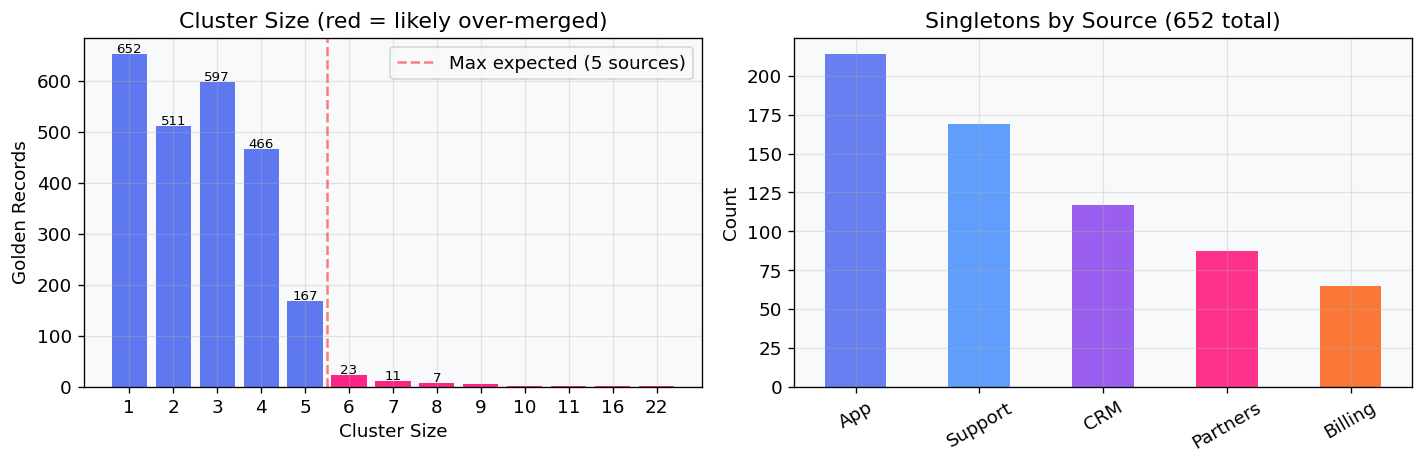


Clusters > 5 members: 50 - with 5 sources, clusters this large
likely contain multiple distinct people merged together.


In [33]:
# 3. Visualize: cluster size vs expected (5 sources → max legitimate cluster = 5)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: highlight over-merged clusters
ax = axes[0]
cluster_dist = df["member_count"].value_counts().sort_index()
colors_bar = [COLORS[0] if x <= 5 else COLORS[3] for x in cluster_dist.index]
ax.bar(cluster_dist.index.astype(str), cluster_dist.values, color=colors_bar, alpha=0.85)
ax.set_xlabel("Cluster Size")
ax.set_ylabel("Golden Records")
ax.set_title("Cluster Size (red = likely over-merged)")
ax.axvline(x=4.5, color="red", linestyle="--", alpha=0.5, label="Max expected (5 sources)")
ax.legend()
for i, (idx, val) in enumerate(cluster_dist.items()):
    if val > 5:
        ax.text(i, val + 3, f"{val}", ha="center", fontsize=8)

# Right: singleton analysis - are these truly unique or missed merges?
ax = axes[1]
singletons = df[df["member_count"] == 1]
singleton_sources = []
for _, row in singletons.iterrows():
    for src, col in source_id_cols.items():
        if pd.notna(row.get(col)) and row.get(col) != "":
            singleton_sources.append(src)
            break
singleton_by_source = pd.Series(singleton_sources).value_counts()
singleton_by_source.plot.bar(ax=ax, color=COLORS[:len(singleton_by_source)], alpha=0.8)
ax.set_title(f"Singletons by Source ({len(singletons):,} total)")
ax.set_ylabel("Count")
ax.tick_params(axis="x", rotation=30)

plt.tight_layout()
plt.show()

over5 = (df["member_count"] > 5).sum()
print(f"\nClusters > 5 members: {over5} - with 5 sources, clusters this large")
print(f"likely contain multiple distinct people merged together.")

### Spec Tuning Recommendations

Based on the golden record analysis above, here's what to adjust in `kanoniv.yml`:

#### 1. Raise the FS match threshold (reduce over-merging)

The current `match: 8.0` is too permissive - it lets weak multi-field fuzzy matches through. Clusters of 10-22 members are a clear sign of **transitive chain merging** (A matches B, B matches C, ... forming a long chain).

```yaml
# BEFORE
thresholds:
  match: 8.0
  possible: 4.0

# AFTER - tighter match boundary
thresholds:
  match: 12.0    # Require email + at least one strong field
  possible: 6.0  # Raise review floor too
```

**Why 12.0?** Email agreement alone contributes ~19.8 weighted score. Name+company together contribute ~14.9. A threshold of 12.0 means you need email OR (phone + name + company) - no more merging on last_name+company alone.

#### 2. Tighten the `[company_name, last_name]` blocking key

This key generates too many candidate pairs for common last names. Two different "Smiths" at the same company will always be compared and may fuzzy-match.

```yaml
# BEFORE
keys:
  - [email]
  - [phone]
  - [last_name, first_name]
  - [company_name, last_name]

# AFTER - add first_name to the company blocking key
keys:
  - [email]
  - [phone]
  - [last_name, first_name]
  - [company_name, last_name, first_name]  # 3-field block = much tighter
```

#### 3. Switch name survivorship from `most_complete` to `source_priority`

`most_complete` picks the longest non-null value - but "Vlizabeth" is longer than "" and wins over the CRM's clean "Elizabeth". CRM is the system of record; trust it for names.

```yaml
# BEFORE
overrides:
  - field: first_name
    strategy: most_complete
  - field: last_name
    strategy: most_complete

# AFTER - CRM names are cleanest
overrides:
  - field: first_name
    strategy: source_priority
    priority: [crm_contacts, billing_accounts, support_users, app_signups, partner_leads]
  - field: last_name
    strategy: source_priority
    priority: [crm_contacts, billing_accounts, support_users, app_signups, partner_leads]
```

#### 4. Lower `company_name` weight (reduce false merges within companies)

Two people at the same company matching on company_name + fuzzy last_name shouldn't be enough to merge. The current weight of 1.0 contributes ~5.3 to the score - too much for a weak signal.

```yaml
# BEFORE
- name: company_name
  comparator: jaro_winkler
  weight: 1.0

# AFTER - demote company as a matching signal
- name: company_name
  comparator: jaro_winkler
  weight: 0.5    # Company agreement is supporting evidence, not primary
```

#### Summary of expected impact

| Tweak | Effect |
|-------|--------|
| Raise match threshold to 12.0 | Eliminates transitive chain merges, clusters cap at ~5 |
| Tighten company blocking key | Fewer false candidate pairs, faster runtime |
| Source-priority names | Clean CRM names win over typo-ridden App/Support data |
| Lower company weight | Two people at the same company no longer merge on name similarity alone |

In [34]:
# Golden records already contain billing fields (plan, mrr_cents, status) through survivorship.
# We just need to parse them and join the AGGREGATE data (invoices, tickets) from related tables.

enriched = df.copy()

# Parse mrr_cents → mrr_usd (it comes through as a string from survivorship)
if "mrr_cents" in enriched.columns:
    enriched["mrr_usd"] = pd.to_numeric(enriched["mrr_cents"], errors="coerce") / 100
else:
    enriched["mrr_usd"] = np.nan

# Join invoice totals (aggregated from billing_invoices table)
invoice_totals = (
    invoices.groupby("billing_account_id")
    .agg(total_invoiced=pd.NamedAgg("amount_cents", "sum"),
         invoice_count=pd.NamedAgg("invoice_id", "count"))
    .reset_index()
)
invoice_totals["total_invoiced_usd"] = invoice_totals["total_invoiced"] / 100

enriched = enriched.merge(
    invoice_totals[["billing_account_id", "total_invoiced_usd", "invoice_count"]],
    on="billing_account_id", how="left"
)

# Join support ticket counts (aggregated from support_tickets table)
ticket_counts = (
    tickets.groupby("support_user_id")
    .agg(ticket_count=pd.NamedAgg("ticket_id", "count"),
         high_priority_tickets=pd.NamedAgg("priority", lambda x: (x.isin(["high", "urgent"])).sum()))
    .reset_index()
)

enriched = enriched.merge(ticket_counts, on="support_user_id", how="left")

print(f"Enriched golden records: {len(enriched):,} rows × {enriched.shape[1]} columns")
print(f"With billing data: {enriched['mrr_usd'].notna().sum():,}")
print(f"With support data: {enriched['ticket_count'].notna().sum():,}")

Enriched golden records: 2,443 rows × 39 columns
With billing data: 1,187
With support data: 1,363


In [35]:
# Show the enriched customer 360 view
# 'plan' and 'status' come from survivorship; 'mrr_usd' was parsed; invoices/tickets were joined
c360_cols = ["kanoniv_id", "first_name", "last_name", "email", "company_name",
             "plan", "mrr_usd", "total_invoiced_usd", "ticket_count",
             "high_priority_tickets", "member_count"]
# Only show columns that actually exist
c360_cols = [c for c in c360_cols if c in enriched.columns]

enriched_with_billing = enriched[enriched["mrr_usd"].notna()].copy()
enriched_with_billing.nlargest(10, "mrr_usd")[c360_cols]

,kanoniv_id,first_name,last_name,email,company_name,plan,mrr_usd,total_invoiced_usd,ticket_count,high_priority_tickets,member_count
1,knv_6dd926260fd5,Anndrea,Williams,steven.williams@cloudpeak.com,CloudPeak Technologies,enterprise,5000.0,5359.58,2.0,1.0,9
9,knv_8fb28188b603,mark,Rooss,mark.ross@redwood.com,RedwoodIndustries,enterprise,5000.0,4869.19,2.0,1.0,5
13,knv_cc411aa41e10,Stephen,Morales,stephen.morales@sapphire.com,Sapphire Analytics,starter,5000.0,3108.60,NaN,NaN,4
27,knv_8c571de98c39,Jeffrey,Sanders,carol.sanders@northstar.io,NorthStar Systems,starter,5000.0,7053.12,2.0,0.0,7
29,knv_f505dbe8c806,Joyce,Torres,joyce.torres@redwood.com,Redwood Industries,growth,5000.0,2169.27,2.0,1.0,4
35,knv_f2862f09fa8a,Betty,Wtason,betty.watson@harbor.io,Harbor Analytics,enterprise,5000.0,9098.14,3.0,1.0,4
61,knv_ec02f67b53d0,Joan,Bennett,joan.bennett@pinnacle.com,Pinnacle Financial,starter,5000.0,12568.27,NaN,NaN,3
81,knv_8ebdd011dd87,Andrea,Murphy,andrea.murphy30@icloud.com,Horizon Labs,enterprise,5000.0,4694.79,3.0,2.0,3
88,knv_9579e2adc0e6,Ruth,Diaz,ruth.diaz@pacific.io,Pacific Innovations,enterprise,5000.0,3092.34,3.0,0.0,4
110,knv_794c50610d37,Anna,Wilson,anna.wilson@summit.com,Summit Health,starter,5000.0,3639.79,NaN,NaN,4


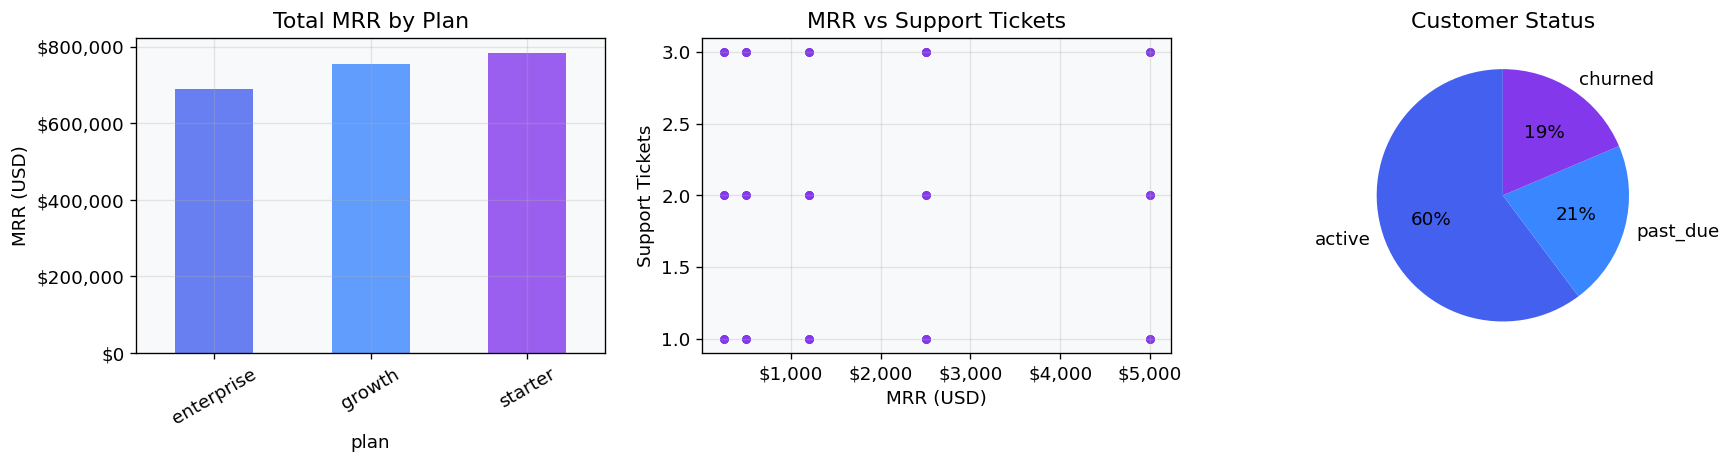

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Revenue distribution by plan (plan column from survivorship, may be string)
ax = axes[0]
if "plan" in enriched_with_billing.columns:
    plan_col = enriched_with_billing["plan"].fillna("unknown")
    plan_revenue = enriched_with_billing.groupby(plan_col)["mrr_usd"].agg(["sum", "count"])
    plan_revenue["sum"].plot.bar(ax=ax, color=COLORS[:len(plan_revenue)], alpha=0.8)
    ax.set_title("Total MRR by Plan")
    ax.set_ylabel("MRR (USD)")
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f"${x:,.0f}"))
    ax.tick_params(axis="x", rotation=30)
else:
    ax.text(0.5, 0.5, "No plan data", transform=ax.transAxes, ha="center")
    ax.set_title("Total MRR by Plan")

# 2. Support tickets vs MRR
ax = axes[1]
both = enriched[enriched["mrr_usd"].notna() & enriched["ticket_count"].notna()]
if len(both) > 0:
    ax.scatter(both["mrr_usd"], both["ticket_count"], alpha=0.3, s=15, color=COLORS[2])
ax.set_xlabel("MRR (USD)")
ax.set_ylabel("Support Tickets")
ax.set_title("MRR vs Support Tickets")
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f"${x:,.0f}"))

# 3. Billing status distribution
ax = axes[2]
if "status" in enriched_with_billing.columns:
    status_counts = enriched_with_billing["status"].fillna("unknown").value_counts()
    ax.pie(status_counts, labels=status_counts.index, autopct="%1.0f%%",
           colors=COLORS[:len(status_counts)], startangle=90)
ax.set_title("Customer Status")

plt.tight_layout()
plt.show()

In [37]:
# Find high-value customers with many support tickets (at-risk)
at_risk = enriched[
    (enriched["mrr_usd"].notna()) &
    (enriched["mrr_usd"] >= 1000) &
    (enriched["high_priority_tickets"].notna()) &
    (enriched["high_priority_tickets"] >= 2)
].sort_values("mrr_usd", ascending=False)

at_risk_cols = ["kanoniv_id", "first_name", "last_name", "company_name",
                "mrr_usd", "ticket_count", "high_priority_tickets"]
at_risk_cols = [c for c in at_risk_cols if c in at_risk.columns]

print(f"High-value customers with 2+ high-priority tickets: {len(at_risk):,}\n")
at_risk[at_risk_cols].head(10)

High-value customers with 2+ high-priority tickets: 76



,kanoniv_id,first_name,last_name,company_name,mrr_usd,ticket_count,high_priority_tickets
131,knv_3a55b3393eaf,Nancy,Williams,Granite Holdings,5000.0,3.0,2.0
174,knv_6cc440a562b4,aKtherine,Hughes,Ironclad Security,5000.0,2.0,2.0
81,knv_8ebdd011dd87,Andrea,Murphy,Horizon Labs,5000.0,3.0,2.0
1697,knv_0c73e7f55585,benjamin,young,Vertex Software,5000.0,2.0,2.0
2003,knv_f9c331d395b3,Carolyn,Morales,CloudPeak Technologies,5000.0,3.0,2.0
537,knv_2288594a11bb,Anthony,Peterson,Cobalt Engineering,5000.0,3.0,2.0
923,knv_02607104ebd0,Melissa,Nelson,Coral Networks,5000.0,3.0,2.0
663,knv_4d7e350b85f2,Kelly,King,Nova Computing,5000.0,2.0,2.0
473,knv_5cb90ad2e2d3,Nicholas,Robinson,Ridge Financial,5000.0,3.0,2.0
483,knv_acd7c013df0b,Wamela,Alvarez,CloudPeak Technologies,5000.0,3.0,2.0


---
## Part 8 - Evaluation

`result.evaluate()` returns a 3-layer analysis of the reconciliation run:

1. **Structural** - cluster counts, merge rate, singletons, size distribution
2. **Stability** - per-field match rates from the engine's telemetry, blocking efficiency
3. **Ground truth** (optional) - precision/recall/F1 when you have labeled data

Layers 1 and 2 are always available with no labels needed - useful for production monitoring.

In [ ]:
# Evaluate the reconciliation run (no labels needed)
metrics = result.evaluate()
print(metrics.summary())

In [ ]:
# Visualize field-level match rates from telemetry
if metrics.field_stats:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    fields = [fs["field"] for fs in metrics.field_stats]
    avg_scores = [fs["avg_score"] for fs in metrics.field_stats]
    match_rates = [
        fs["matched"] / fs["evaluated"] if fs["evaluated"] > 0 else 0.0
        for fs in metrics.field_stats
    ]

    # Left: average match score per field
    ax = axes[0]
    bars = ax.barh(fields, avg_scores, color=COLORS[0], alpha=0.85)
    ax.set_xlabel("Average Score")
    ax.set_title("Field Match Scores")
    for bar, val in zip(bars, avg_scores):
        ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                f"{val:.3f}", va="center", fontsize=9)

    # Right: match rate per field
    ax = axes[1]
    bars = ax.barh(fields, match_rates, color=COLORS[2], alpha=0.85)
    ax.set_xlabel("Match Rate")
    ax.set_title("Field Match Rate (matched / evaluated)")
    ax.set_xlim(0, 1.0)
    for bar, val in zip(bars, match_rates):
        ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                f"{val:.1%}", va="center", fontsize=9)

    plt.tight_layout()
    plt.show()

print(f"\nBlocking groups:  {metrics.blocking_groups:,}")
print(f"Pairs evaluated:  {metrics.pairs_evaluated:,}")
print(f"Singletons:       {metrics.singletons:,} ({metrics.singletons_pct:.1%})")
print(f"Largest cluster:  {metrics.largest_cluster}")

**What's available locally vs cloud:**

| Tool | Where | What it answers |
|------|-------|-----------------|
| `result.evaluate()` | Local SDK | How good is this run? (structural + stability + optional GT) |
| `sensitivity()` | Cloud | How fragile is this spec? (field dependency analysis) |
| `result.compare(other)` | Cloud | Did identity boundaries shift? (run-vs-run drift detection) |

---
## Summary

### What Kanoniv Did

In [38]:
summary_data = pd.DataFrame([
    {"Metric": "Input records", "Value": f"{total_input:,}"},
    {"Metric": "Source systems", "Value": "5"},
    {"Metric": "Golden records", "Value": f"{result.cluster_count:,}"},
    {"Metric": "Merge rate", "Value": f"{result.merge_rate:.1%}"},
    {"Metric": "Compression", "Value": f"{total_input / result.cluster_count:.1f}x"},
    {"Metric": "Singletons", "Value": f"{(df['member_count'] == 1).sum():,}"},
    {"Metric": "Merged (2+ sources)", "Value": f"{(df['member_count'] >= 2).sum():,}"},
    {"Metric": "Runtime", "Value": f"{elapsed:.2f}s"},
]).set_index("Metric")

summary_data

,Value
Metric,
Input records,"6,539"
Source systems,5
Golden records,"2,443"
Merge rate,62.6%
Compression,2.7x
Singletons,652
Merged (2+ sources),"1,791"
Runtime,0.42s


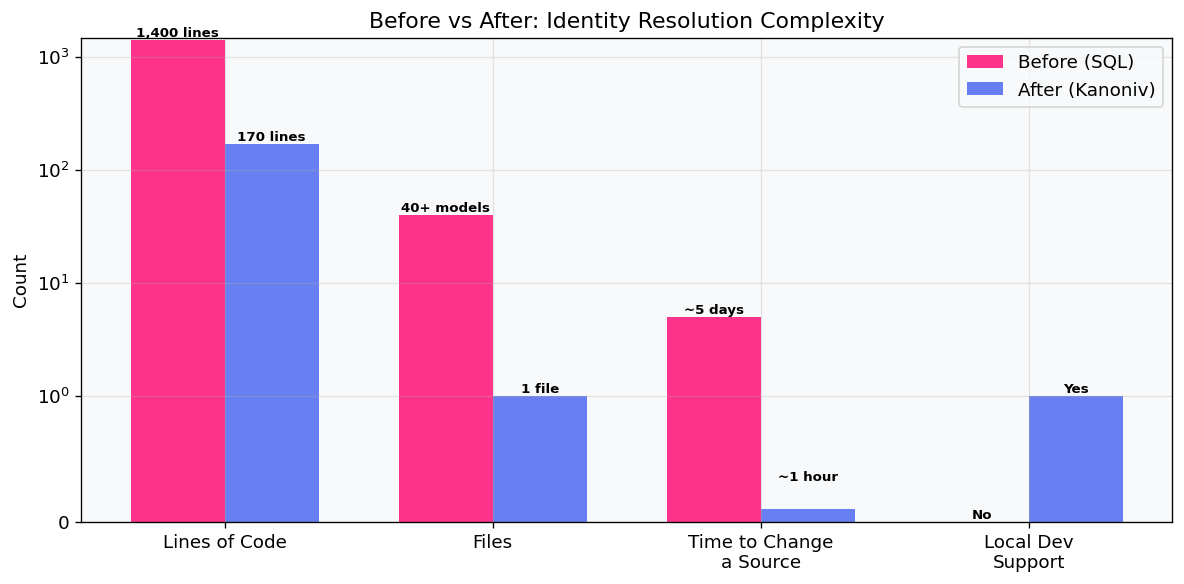

In [39]:
fig, ax = plt.subplots(figsize=(10, 5))

categories = ["Lines of Code", "Files", "Time to Change\na Source", "Local Dev\nSupport"]
before_vals = [1400, 40, 5, 0]  # SQL lines, SQL files, days, no
after_vals = [170, 1, 0.1, 1]   # YAML lines, 1 file, hours, yes

x = np.arange(len(categories))
width = 0.35

bars1 = ax.bar(x - width/2, before_vals, width, label="Before (SQL)",
               color=COLORS[3], alpha=0.8)
bars2 = ax.bar(x + width/2, after_vals, width, label="After (Kanoniv)",
               color=COLORS[0], alpha=0.8)

ax.set_ylabel("Count")
ax.set_title("Before vs After: Identity Resolution Complexity")
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
ax.set_yscale("symlog", linthresh=1)

labels_before = ["1,400 lines", "40+ models", "~5 days", "No"]
labels_after = ["170 lines", "1 file", "~1 hour", "Yes"]
for bar, label in zip(bars1, labels_before):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
            label, ha="center", va="bottom", fontsize=8, fontweight="bold")
for bar, label in zip(bars2, labels_after):
    ax.text(bar.get_x() + bar.get_width()/2, max(bar.get_height(), 0.3),
            label, ha="center", va="bottom", fontsize=8, fontweight="bold")

plt.tight_layout()
plt.show()

### Key Takeaways

1. **Declarative > Imperative** - 170 lines of YAML replaces 1,400 lines of SQL. Add a new source by adding 10 lines, not 200.

2. **Probabilistic > Deterministic** - Fellegi-Sunter with EM training adapts to your data. Nickname normalization catches Bob=Robert, Liz=Elizabeth without manual rules.

3. **Local-first** - The entire engine runs on your laptop via PyO3. No cloud API, no network calls, no data leaves your machine.

4. **Every entity gets a Kanoniv ID** - Deterministic, stable, traceable. The same inputs always produce the same ID.

5. **Golden records enable Customer 360** - Join billing, support, and any other operational data to the unified entity for at-risk identification, upsell targeting, and more.

6. **Governance built in** - Freshness constraints, schema validation, PII tagging, audit logging, and shadow-mode threshold protection are part of the spec, not an afterthought.